In [4]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd import grad

from scipy.linalg import orth
from numpy.linalg import eig
from numpy.linalg import svd

%matplotlib inline

In [5]:
# AdaM: Adaptive Moments Optimizer
## Params
### alpha0: base learning rate
### grad: current gradient
### adam_values: dictionary containing moment estimates

def get_AdaM_update(alpha_0, grad, adam_values, b1=.95, b2=.999, e=1e-8):
    adam_values['t'] += 1

    # update mean                                                                                                                                                                                                     
    adam_values['mean'] = b1 * adam_values['mean'] + (1-b1) * grad
    m_hat = adam_values['mean'] / (1-b1**adam_values['t'])

    # update variance                                                                                                                                                                                                 
    adam_values['var'] = b2 * adam_values['var'] + (1-b2) * grad**2
    v_hat = adam_values['var'] / (1-b2**adam_values['t'])

    return alpha_0 * m_hat/(np.sqrt(v_hat) + e)

## Probabilistic Distillation of Neural Networks
#### by [Eric Nalisnick](http://www.ics.uci.edu/~enalisni/) 

Neural network distillation [(Ba and Caruana, 2013)](https://arxiv.org/abs/1312.6184) [(Hinton et al., 2015)](https://arxiv.org/abs/1503.02531) [(Balan et al., 2015)](http://papers.nips.cc/paper/5965-bayesian-dark-knowledge)---where the probabilities produced by a large 'teacher' model are used as targets for training a smaller 'student' model---is crucial for delopying neural networks to systems for which runtime and memory are limited.  This notebook proposes a new strategy for *probabilistic* distillation, providing a distribution over various simpler models.  Moreover, the proposed method has the benefits that (1) the student model does not need its own optimization loop and (2) as the students are mixtures of linear models, they allow for a high degree of interpretability.    

### 1.  Linearizing Neural Networks
Before introducing our novel method, we review a technique proposed by [Wang et al. (ICML 2016)](http://proceedings.mlr.press/v48/wanga16.pdf) for linearizing deep neural networks.  Assume we have a trained neural network with ReLU activations.  For a given datapoint $\mathbf{x}_{i}$, we begin its propagation through the network by computing the first hidden states as $\mathbf{h}_{i,1} = \text{ReLU}(\mathbf{x}_{i} \mathbf{W}_{1})$.  Yet, notice that for any hidden state $h_{i,1,j} = 0$, we could achive the same $\mathbf{h}_{i,1}$ by setting the $j$th column of $\mathbf{W}_{1}$ to all zeros.  The ReLU function would then be superflous, and the hidden units could be expressed simply as a multiplication, i.e. $\mathbf{h}_{i,1} = \mathbf{x}_{i} \tilde{\mathbf{W}}_{1}$ where $\tilde{\mathbf{W}}_{1}$ is $\mathbf{W}_{1}$ but with the appropriate columns masked to zero.  Repeating this process for all layers in the network, we get a composition of linear transformations, which is itself linear: $$ g(\boldsymbol{\mu}^{Y}_{i}) \ \ = \ \ \mathbf{x}_{i} \tilde{\mathbf{W}}_{1} \tilde{\mathbf{W}}_{2} \ldots \mathbf{W}_{L} \ \ = \ \ \mathbf{x}_{i} \tilde{\mathbf{U}}_{i}$$ where $g(\cdot)$ is the link function, $\boldsymbol{\mu}_{Y}$ is the mean of the label/response distribuiton, and $\tilde{\mathbf{U}}_{i}$ is the product of all masked linear transformations.  Interestingly, $\tilde{\mathbf{U}}_{i}$ is equivalent to the output gradient taken w.r.t. the input: $$ \frac{\partial g(\boldsymbol{\mu}^{Y}_{i})}{\partial \mathbf{x}_{i}} \  = \  \frac{\partial g(\boldsymbol{\mu}^{Y}_{i})}{\partial \mathbf{h}_{i, L}} \  \frac{\partial \mathbf{h}_{i,L}}{\partial \mathbf{h}_{i, L-1}} \ldots \frac{\partial \mathbf{h}_{i,2}}{\partial \mathbf{h}_{i, 1}} \ \frac{\partial \mathbf{h}_{i,1}}{\partial \mathbf{x}_{i}} \ = \ \mathbf{W}_{L}\tilde{\mathbf{W}}_{L-1}\ldots\tilde{\mathbf{W}}_{1} \ = \ \tilde{\mathbf{U}}_{i}^{T}. $$  Furthermore, this equivalence holds for convolutional networks with ReLU activations and max or average pooling.       

Collecting all $\tilde{\mathbf{U}}_{i}$'s across the training set, we can write the whole neural network as piecewise linear function---or in other words, a mixture of $N$ linear experts, one for each training datapoint: $$ g(\boldsymbol{\mu}^{Y}) \ = \  f(\mathbf{x}; \{ \tilde{\mathbf{U}}_{1}, \tilde{\mathbf{U}}_{2}, \ldots, \tilde{\mathbf{U}}_{N} \}) = \sum_{i=1}^{N} \pi_{i}(\mathbf{x}) \ \mathbf{x}  \tilde{\mathbf{U}}_{i}  \ \ \ \text{where} \ \ \ \pi_{i}(\mathbf{x}) = \frac{k(\mathbf{x}, \mathbf{x}_{i}; \beta)}{\sum_{j=1}^{N} k(\mathbf{x}, \mathbf{x}_{j}; \beta)}$$ where $\pi_{i}(\mathbf{x})$ is a gating function comprised of kernels and $\beta$ is a scale parameter for the kernels.  Notice that sending $\beta \rightarrow 0$ results in $\pi(\cdot)$ becoming a hard assignment and thus allows the mixture to produce exactly the same output on the training set as the original model.  

####  Experiment: Regression Simulation

Let's now demonstrate how to find the mixture of experts representation a network trained on one-dimensional data...

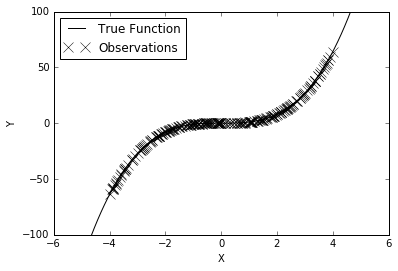

In [6]:
# Simulate N observations from a cubic function
N = 250
x = np.array([np.random.uniform(-4,4) for n in range(N)])[np.newaxis].T
y = x**3

# True function
x_true = np.linspace(start=-6, stop=6, num=100)
y_true = x_true**3

plt.plot(x_true, y_true, 'k-', label="True Function")
plt.plot(x, y, 'xk', ms=10, linewidth=1, label="Observations")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

Next let's define the model: a one-hidden-layer neural network with 50 units...

In [7]:
# Regression NN with one hidden layer of 50 units
def logModel(W, b, x, y):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    y_hat = np.dot(h, W[:, 50:].T) + b[:, 50:]
    return np.sum( .5 * -(y - y_hat)**2 )

def fprop(W, b, x):
    h = np.maximum(np.dot(x, W[:, :50]) + b[:, :50], 0.)
    return np.dot(h, W[:, 50:].T) + b[:, 50:]


### GET DERIVATIVES ###
# d log p(X | \theta) / d \theta
dLogModel_dW = grad(logModel)
dLogModel_db = grad(lambda b, W, x, y: logModel(W, b, x, y))

Now let's train the NN...

In [8]:
### INIT PARAMS 
theta = {'W': .001 * np.random.normal(size=(1,100)), 'b': np.zeros((1,51))}

### ELBO OPTIMIZATION
maxEpochs = 1000
learning_rate = .01
adam_values = {'W':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

loss = 0.
for epochIdx in range(maxEpochs):
    
    dModel_dW = dLogModel_dW(theta['W'], theta['b'], x, y) 
    dModel_db = dLogModel_db(theta['b'], theta['W'], x, y)
        
    theta['W'] += get_AdaM_update(learning_rate, dModel_dW, adam_values['W'])  
    theta['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b'])
    
    loss += logModel(theta['W'], theta['b'], x, y)
    if (epochIdx+1) % 100 == 0:
        print "%d. Neg. Log Likelihood: %.3f" %(epochIdx+1, -loss/5.)
        loss = 0.

100. Neg. Log Likelihood: 680576.770
200. Neg. Log Likelihood: 266360.598
300. Neg. Log Likelihood: 143453.434
400. Neg. Log Likelihood: 66263.682
500. Neg. Log Likelihood: 32330.793
600. Neg. Log Likelihood: 20250.655
700. Neg. Log Likelihood: 15538.806
800. Neg. Log Likelihood: 11253.891
900. Neg. Log Likelihood: 7006.680
1000. Neg. Log Likelihood: 4492.129


And visualize the results...

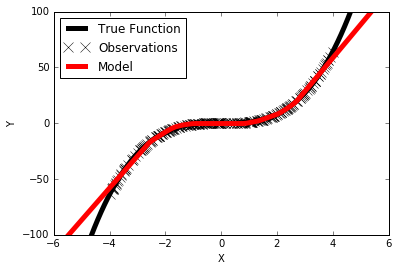

In [9]:
plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x, y, 'xk', ms=10, linewidth=1, label="Observations")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=5, label="Model")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### Linearizing the Network

Next let's write a function that extracts $\tilde{\mathbf{U}}_{i}$ for each $\mathbf{x}_{i}$...

In [10]:
def get_linear_transform(x_i, W, b):
    #copy
    W_tilde = np.array(W)
    b_tilde = np.array(b)
    
    # fprop
    h = np.maximum(np.dot(x_i, W[:, :50]) + b[:, :50], 0.)
    
    # apply mask
    for j in range(50):
        if h[0, j] == 0: 
            W_tilde[:, j] = 0.
            b_tilde[:, j] = 0.
            
    # construct matrices
    W1_tilde = np.vstack([W_tilde[:, :50], b_tilde[:, :50]]) #add bias
    next_bias = np.hstack([1./x_i, np.zeros((1,1))]).T
    W1_tilde = np.hstack([W1_tilde, next_bias]) # add bias for next layer
    
    W2_tilde = np.vstack([W_tilde[:, 50:].T, b_tilde[:, 50:]]) #add bias
    
    return np.dot(W1_tilde, W2_tilde)

Next we calculate all the $\tilde{\mathbf{U}}$ vectors...

In [11]:
x = np.sort(x, axis=0)

U_vectors = []
for i in range(N):
    U_vectors.append( get_linear_transform(x[i,:][np.newaxis], theta['W'], theta['b'])[:,0] )
U_vectors = np.array(U_vectors).T

Define a kernel function and calculate it between all pairs...

In [12]:
def kernel(x1, x2, beta=.1):
    #if x1[0] == x2[0]: return 1.
    #return 0
    return np.exp(-np.sum((x1-x2)**2)/beta)

kernel_vals = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        kernel_vals[i,j] = kernel(x[i], x[j])
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

#### Training Data Result

Visualize the result on the training data..

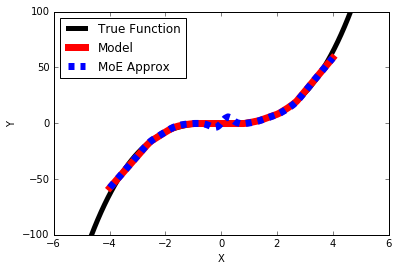

In [13]:
x_w_bias = np.hstack([x, np.ones((N,1))])
yHat_MoE = np.sum(np.dot(x_w_bias, U_vectors) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x, fprop(theta['W'], theta['b'], x), 'r-', linewidth=7, label="Model")
plt.plot(x, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### Test Data Result

Visualize the result for the true function...

In [14]:
kernel_vals = np.zeros((100, N))
beta_val = .1

for i in range(100):
    for j in range(N):
        kernel_vals[i,j] = kernel(x_true[i], x[j], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

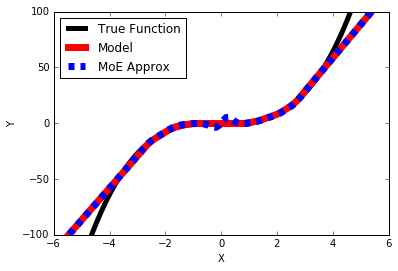

In [15]:
xTrue_w_bias = np.hstack([x_true[np.newaxis].T, np.ones((100,1))])
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_vectors) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

### 2.  Pruning Experts 
Using the above mixture of experts representation in place of the original model requires $\mathcal{O}(Nd)$ time, as it depends on the number of training points, which is a dependence we'd like to break.  Hence, we would like form a good approximation using only a subset of the experts: $$ f(\mathbf{x}; \{ \tilde{\mathbf{U}}_{1}, \tilde{\mathbf{U}}_{2}, \ldots, \tilde{\mathbf{U}}_{N} \}) \  \approx  \  \sum_{k=1}^{K} \pi_{k}(\mathbf{x}) \ \mathbf{x}  \tilde{\mathbf{U}}_{k}$$ for $K<<N$.  How should we choose the subset?  Below we attempt several different strategies...

#### A.  Random Sampling
We start with a naive solution: random sampling.  We sample $K$ pairs $\{\mathbf{x}_{k}, \tilde{\mathbf{U}}_{k} \}$ without replacement from the set of $N$.     

In [16]:
K = 4
k_idxs = np.random.choice(N, K)

kernel_vals = np.zeros((100, K))
beta_val = 1.

for i in range(100):
    for j, k in enumerate(k_idxs):
        kernel_vals[i,j] = kernel(x_true[i], x[k], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

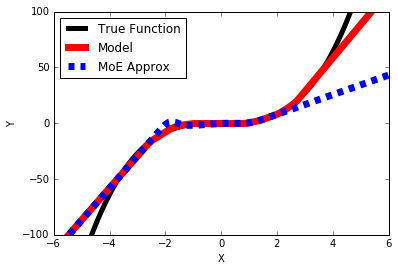

In [17]:
U_subset = U_vectors[:, k_idxs]
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_subset) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### B.  Regular Sampling
We continue with another naive solution: sampling regular interval.  We sample $K$ pairs $\{\mathbf{x}_{k}, \tilde{\mathbf{U}}_{k} \}$ by choosing every $N/k$th ordered point.     

In [18]:
K = 4
k_idxs = [0] + [k * N/(K-1) for k in range(1, K-1)] + [N-1]
print k_idxs

kernel_vals = np.zeros((100, K))

for i in range(100):
    for j, k in enumerate(k_idxs):
        kernel_vals[i,j] = kernel(x_true[i], x[k], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

[0, 83, 166, 249]


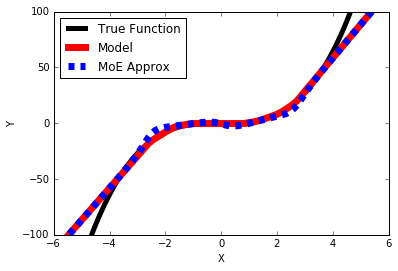

In [19]:
U_subset = U_vectors[:, k_idxs]
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_subset) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### C.   Douglas-Peucker Algorithm
For polylines, there is a recursive simplification algorithm known as the [Douglas-Peucker Algorithm](https://en.wikipedia.org/wiki/Ramer%E2%80%93Douglas%E2%80%93Peucker_algorithm).  It has an expected runtime of $\mathcal{O}(N \log N)$.     

In [20]:
import math
import time


def timenow():
    return int(time.time() * 1000)

def sqr(x):
    return x*x

def distSquared(p1, p2):
    return sqr(p1[0] - p2[0]) + sqr(p1[1] - p2[1])

class Line(object):
    def __init__(self, p1, p2):
        self.p1 = p1
        self.p2 = p2
        self.lengthSquared = distSquared(self.p1, self.p2)

    def getRatio(self, point):
        segmentLength = self.lengthSquared
        if segmentLength == 0:
            return distSquared(point, p1);
        return ((point[0] - self.p1[0]) * (self.p2[0] - self.p1[0]) + \
        (point[1] - self.p1[1]) * (self.p2[1] - self.p1[1])) / segmentLength

    def distanceToSquared(self, point):
        t = self.getRatio(point)

        if t < 0:
            return distSquared(point, self.p1)
        if t > 1:
            return distSquared(point, self.p2)

        return distSquared(point, [
            self.p1[0] + t * (self.p2[0] - self.p1[0]),
            self.p1[1] + t * (self.p2[1] - self.p1[1])
        ])

    def distanceTo(self, point):
        return math.sqrt(self.distanceToSquared(point))


def simplifyDouglasPeucker(points, pointsToKeep):
    weights = []
    length = len(points)

    def douglasPeucker(start, end):
        if (end > start + 1):
            line = Line(points[start], points[end])
            maxDist = -1
            maxDistIndex = 0

            for i in range(start + 1, end):
                dist = line.distanceToSquared(points[i])
                if dist > maxDist:
                    maxDist = dist
                    maxDistIndex = i

            weights.insert(maxDistIndex, maxDist)

            douglasPeucker(start, maxDistIndex)
            douglasPeucker(maxDistIndex, end)

    douglasPeucker(0, length - 1)
    weights.insert(0, float("inf"))
    weights.append(float("inf"))

    weightsDescending = weights
    weightsDescending = sorted(weightsDescending, reverse=True)

    maxTolerance = weightsDescending[pointsToKeep - 1]
    result = [
        point for i, point in enumerate(points) if weights[i] >= maxTolerance
    ]

    return result

In [21]:
K = 4
point_tups = zip(x[:,0].tolist(), fprop(theta['W'], theta['b'], x)[:,0].tolist())
points_kept = simplifyDouglasPeucker(points=point_tups, pointsToKeep=K)
k_idxs = [point_tups.index(p) for p in points_kept]

kernel_vals = np.zeros((100, K))

for i in range(100):
    for j, k in enumerate(k_idxs):
        kernel_vals[i,j] = kernel(x_true[i], x[k], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

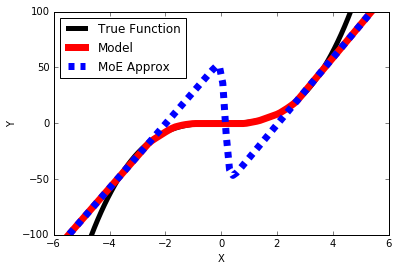

In [22]:
U_subset = U_vectors[:, k_idxs]
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_subset) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### D.   Sensitivity-Based Pruning
Recall that $\tilde{\mathbf{U}}_{i} = \frac{\partial g(\boldsymbol{\mu}^{Y}_{i})}{\partial \mathbf{x}_{i}}$, and therefore  $|| \tilde{\mathbf{U}}_{i}|| = || \frac{\partial g(\boldsymbol{\mu}^{Y}_{i})}{\partial \mathbf{x}_{i}} ||$.  In other words, the linear transformations with the largest norms are the ones most sensitive to the input $\mathbf{x}$, changing their output quickly with small changes to the input.  It is reasonable to think that these transformations have the least chance of generalizing and therefore should be the ones that are pruned.  In classification settings, we may prune for each class separately.

In [23]:
K = 8
k_idxs = ((np.sum(U_vectors**2, axis=0))).argsort()[N/2-K/2:-(N/2-K/2)]
print k_idxs

kernel_vals = np.zeros((100, K))

for i in range(100):
    for j, k in enumerate(k_idxs):
        kernel_vals[i,j] = kernel(x_true[i], x[k], beta_val)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

[191  60  61  62  63  64  65  66]


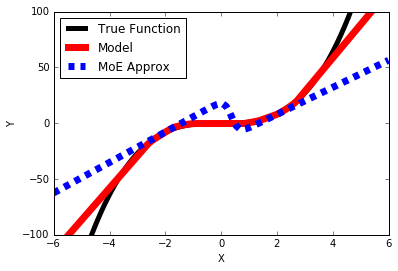

In [24]:
U_subset = U_vectors[:, k_idxs]
yHat_MoE = np.sum(np.dot(xTrue_w_bias, U_subset) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

#### E.   Low-Rank Representation
Instead of pruning $\tilde{\mathbf{U}}_{i}$'s, we can simply try to find a low-rank representation that takes all transformations into account: $\tilde{\mathbf{U}}_{d \times N} = \mathbf{V}_{d \times K} \mathbf{Q}_{K \times N}$.  The $\mathbf{V}$ matrix can then be used to make predictions.  If $\tilde{\mathbf{U}}_{i}$ is a matrix, then we must perform tensor decomposition.  In order to formulate the kernel weighting function, we'll need to change the basis of the original dataset via $\mathbf{Q}\mathbf{X} = \mathbf{Z}_{K \times d}$

In [25]:
K=2
V,S,Q = svd(U_vectors, full_matrices=False)
S = np.diag(S)
Z_train = np.dot(Q, x)  # K X d

kernel_vals = np.zeros((100, K))
k_idxs = [0, 1]
for i in range(100):
    for j, k in enumerate(k_idxs):
        kernel_vals[i,j] = kernel(x_true[i], Z_train[k], 1.)
        
kernel_vals = kernel_vals / (kernel_vals.sum(axis=1)[np.newaxis].T)

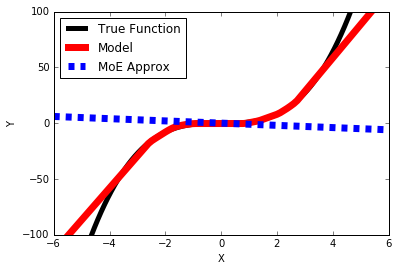

In [26]:
yHat_MoE = np.sum(np.dot(xTrue_w_bias, V) * kernel_vals, axis=1)

plt.plot(x_true, y_true, 'k-', linewidth=5, label="True Function")
plt.plot(x_true, fprop(theta['W'], theta['b'], x_true[np.newaxis].T), 'r-', linewidth=7, label="Model")
plt.plot(x_true, yHat_MoE, 'b--', linewidth=7, label="MoE Approx")

plt.xlabel("X")
plt.ylabel("Y")
plt.xlim([-6, 6])
plt.ylim([-100, 100])

plt.legend(loc=2)
plt.show()

### 3.  Experiment: MNIST
We now test the above pruning strategy on a more realistic example, MNIST.  Let's load the data...

In [29]:
from sklearn.datasets import fetch_mldata
from random import shuffle

mnist = fetch_mldata('MNIST original')

# reduce dataset and normalize to [0,1]
random_idxs = range(mnist.data.shape[0])
shuffle(random_idxs)
train_x = mnist.data[random_idxs[:10000],:] / 255.
test_x = mnist.data[random_idxs[10000:15000],:] / 255.
train_y = np.zeros((10000, 10))
for i, y in enumerate(mnist.target[random_idxs[:10000]]):
    train_y[i, y] = 1.
test_y = mnist.target[random_idxs[10000:15000]].tolist()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [66]:
N, input_d = train_x.shape
N_test = test_x.shape[0]
hidden_d = 250
n_classes = train_y.shape[1]

def softmax(z):
    y = np.exp(z)
    return y / y.sum()

# Classification NN with one hidden layer
def fprop(W, b, x):
    h = np.maximum(np.dot(x, W[:, :input_d * hidden_d].reshape(input_d, hidden_d)) + b[:, :hidden_d], 0.)
    return softmax(np.dot(h, W[:, input_d * hidden_d:].reshape(hidden_d, n_classes)) + b[:, hidden_d:])

def logModel(W, b, x, y):
    y_hat = fprop(W, b, x)
    return np.mean( y * np.log(y_hat) )

def accuracy(y, y_hat):    
    correct = 0.
    for y, yh in zip(y, y_hat): 
        if y == yh: correct += 1
    return correct / len(y_hat)


### GET DERIVATIVES ###
# d log p(X | \theta) / d \theta
dLogModel_dW = grad(logModel)
dLogModel_db = grad(lambda b, W, x, y: logModel(W, b, x, y))

In [32]:
### INIT PARAMS 
theta = {'W': .001 * np.random.normal(size=(1, input_d*hidden_d + hidden_d*n_classes)), 'b': np.zeros((1, hidden_d + n_classes))}

### ELBO OPTIMIZATION
maxEpochs = 50
batchSize = 100
learning_rate = .0003
adam_values = {'W':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

loss = 0.
for epochIdx in range(maxEpochs):
    
    for batchIdx in range(10000/batchSize):
    
        dModel_dW = dLogModel_dW(theta['W'], theta['b'], train_x[batchIdx*batchSize:(batchIdx+1)*batchSize, :], train_y[batchIdx*batchSize:(batchIdx+1)*batchSize, :]) 
        dModel_db = dLogModel_db(theta['b'], theta['W'], train_x[batchIdx*batchSize:(batchIdx+1)*batchSize, :], train_y[batchIdx*batchSize:(batchIdx+1)*batchSize, :])
        
        theta['W'] += get_AdaM_update(learning_rate, dModel_dW, adam_values['W'])  
        theta['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b'])
    
    loss += logModel(theta['W'], theta['b'], train_x, train_y)
    if (epochIdx+1) % 3 == 0:
        print "%d. Neg. Log Likelihood: %.3f" %(epochIdx+1, -loss/3.)
        loss = 0.

3. Neg. Log Likelihood: 1.005
6. Neg. Log Likelihood: 0.971
9. Neg. Log Likelihood: 0.959
12. Neg. Log Likelihood: 0.952
15. Neg. Log Likelihood: 0.947
18. Neg. Log Likelihood: 0.944
21. Neg. Log Likelihood: 0.941
24. Neg. Log Likelihood: 0.939
27. Neg. Log Likelihood: 0.937
30. Neg. Log Likelihood: 0.935
33. Neg. Log Likelihood: 0.933
36. Neg. Log Likelihood: 0.932
39. Neg. Log Likelihood: 0.931
42. Neg. Log Likelihood: 0.930
45. Neg. Log Likelihood: 0.929
48. Neg. Log Likelihood: 0.928


In [33]:
og_net_train_acc = accuracy(np.argmax(train_y, axis=1).tolist(), np.argmax(fprop(theta['W'], theta['b'], train_x), axis=1).tolist())
og_net_test_acc = accuracy(test_y, np.argmax(fprop(theta['W'], theta['b'], test_x), axis=1).tolist())

print "Train accuracy: %.4f" %(og_net_train_acc)
print "Test accuracy: %.4f" %(og_net_test_acc)

Train accuracy: 0.9943
Test accuracy: 0.9534


In [64]:
def get_linear_transform(x_i, W, b):
    #copy
    W1_tilde = np.array(W[:, :input_d * hidden_d].reshape(input_d, hidden_d))
    W2 = np.array(W[:, input_d * hidden_d:].reshape(hidden_d, n_classes))
    b_tilde = np.array(b)
    
    # fprop
    h = np.maximum(np.dot(x_i, W1_tilde) + b_tilde[:, :hidden_d], 0.)
    
    # apply mask
    for j in range(hidden_d):
        if h[0, j] == 0: 
            W1_tilde[:, j] = np.zeros((input_d))
            b_tilde[:, j] = 0.
            
    # construct matrices
    W1_tilde = np.vstack([W1_tilde, b_tilde[:, :hidden_d]]) #add bias
    next_bias = np.hstack([np.ones((1, input_d))/x_i.sum(), np.zeros((1,1))]).T 
    W1_tilde = np.hstack([W1_tilde, next_bias]) # add bias for next layer
    
    W2_tilde = np.vstack([W2, b_tilde[:, hidden_d:]]) #add bias
    
    return np.dot(W1_tilde, W2_tilde)

In [81]:
U_vectors = []
for i in range(N):
    U_vectors.append( get_linear_transform(train_x[i,:][np.newaxis], theta['W'], theta['b']) )

In [101]:
train_x_w_bias = np.hstack([train_x, np.ones((N,1))])
test_x_w_bias = np.hstack([test_x, np.ones((N_test,1))])
Ks = [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
all_train = []
all_test = []

for K in Ks:
    k_idxs = []
    train_labels = np.argmax(train_y, axis=1).tolist()
    counter = np.ones((n_classes,)) * K
    for k, val in enumerate(train_labels):
        if counter[val] > 0: 
            k_idxs.append(k)
            counter[val] -= 1
        if counter.sum() == 0: break

    beta_val = 5.
    train_kernel_vals = np.zeros((N, K*n_classes))
    test_kernel_vals = np.zeros((N_test, K*n_classes))

    for i in range(N):
        for j,k in enumerate(k_idxs):
            train_kernel_vals[i,j] = kernel(train_x[i], train_x[k], beta_val)
                
    for i in range(N_test):
        for j,k in enumerate(k_idxs):
            test_kernel_vals[i,j] = kernel(test_x[i], train_x[k], beta_val)
        
    train_kernel_vals = train_kernel_vals / (train_kernel_vals.sum(axis=1)[np.newaxis].T)
    test_kernel_vals = test_kernel_vals / (test_kernel_vals.sum(axis=1)[np.newaxis].T)
    
    U_subset = [U_vectors[k] for k in k_idxs]

    temp1 = 0.
    temp2 = 0.
    for k, U in enumerate(U_subset):
        temp1 += np.dot(train_x_w_bias, U) * train_kernel_vals[:,k][np.newaxis].T
        temp2 += np.dot(test_x_w_bias, U) * test_kernel_vals[:,k][np.newaxis].T

    train_yHat_MoE = softmax(temp1)
    test_yHat_MoE = softmax(temp2)

    moe_train_acc = accuracy(np.argmax(train_y, axis=1).tolist(), np.argmax(train_yHat_MoE, axis=1).tolist())
    moe_test_acc = accuracy(test_y, np.argmax(test_yHat_MoE, axis=1).tolist())

    print "Train accuracy for K=%d: %.4f" %(K, moe_train_acc)
    print "Test accuracy for K=%d: %.4f" %(K, moe_test_acc)
    
    all_train.append(moe_train_acc)
    all_test.append(moe_test_acc)

Train accuracy for K=1: 0.8721
Test accuracy for K=1: 0.8462
Train accuracy for K=3: 0.9320
Test accuracy for K=3: 0.9046
Train accuracy for K=5: 0.9347
Test accuracy for K=5: 0.9022
Train accuracy for K=10: 0.9400
Test accuracy for K=10: 0.9118
Train accuracy for K=15: 0.9468
Test accuracy for K=15: 0.9160
Train accuracy for K=20: 0.9527
Test accuracy for K=20: 0.9210
Train accuracy for K=25: 0.9572
Test accuracy for K=25: 0.9230
Train accuracy for K=30: 0.9581
Test accuracy for K=30: 0.9240
Train accuracy for K=35: 0.9601
Test accuracy for K=35: 0.9248
Train accuracy for K=40: 0.9604
Test accuracy for K=40: 0.9260
Train accuracy for K=45: 0.9606
Test accuracy for K=45: 0.9252
Train accuracy for K=50: 0.9617
Test accuracy for K=50: 0.9262


In [106]:
### LINEAR MODEL BASELINE ###
# Classification NN with one hidden layer
def fprop_linear(W, b, x):
    return softmax(np.dot(x, W.reshape(input_d, n_classes)) + b)

def logModel_linear(W, b, x, y):
    y_hat = fprop_linear(W, b, x)
    return np.mean( y * np.log(y_hat) )


### GET DERIVATIVES ###
# d log p(X | \theta) / d \theta
dLogModel_linear_dW = grad(logModel_linear)
dLogModel_linear_db = grad(lambda b, W, x, y: logModel_linear(W, b, x, y))

### INIT PARAMS 
theta = {'W': .001 * np.random.normal(size=(1, input_d*n_classes)), 'b': np.zeros((1, n_classes))}

### ELBO OPTIMIZATION
maxEpochs = 100
batchSize = 100
learning_rate = .0003
adam_values = {'W':{'mean': 0., 'var': 0., 't': 0}, 
               'b':{'mean': 0., 'var': 0., 't': 0}}

loss = 0.
for epochIdx in range(maxEpochs):
    
    for batchIdx in range(10000/batchSize):
    
        dModel_dW = dLogModel_linear_dW(theta['W'], theta['b'], train_x[batchIdx*batchSize:(batchIdx+1)*batchSize, :], train_y[batchIdx*batchSize:(batchIdx+1)*batchSize, :]) 
        dModel_db = dLogModel_linear_db(theta['b'], theta['W'], train_x[batchIdx*batchSize:(batchIdx+1)*batchSize, :], train_y[batchIdx*batchSize:(batchIdx+1)*batchSize, :])
        
        theta['W'] += get_AdaM_update(learning_rate, dModel_dW, adam_values['W'])  
        theta['b'] += get_AdaM_update(learning_rate, dModel_db, adam_values['b'])
    
    loss += logModel_linear(theta['W'], theta['b'], train_x, train_y)
    if (epochIdx+1) % 3 == 0:
        print "%d. Neg. Log Likelihood: %.3f" %(epochIdx+1, -loss/3.)
        loss = 0.
        
baseline_train_acc = accuracy(np.argmax(train_y, axis=1).tolist(), np.argmax(fprop_linear(theta['W'], theta['b'], train_x), axis=1).tolist())
baseline_test_acc = accuracy(test_y, np.argmax(fprop_linear(theta['W'], theta['b'], test_x), axis=1).tolist())

print
print "Train accuracy: %.4f" %(baseline_train_acc)
print "Test accuracy: %.4f" %(baseline_test_acc)

3. Neg. Log Likelihood: 1.034
6. Neg. Log Likelihood: 1.000
9. Neg. Log Likelihood: 0.991
12. Neg. Log Likelihood: 0.986
15. Neg. Log Likelihood: 0.983
18. Neg. Log Likelihood: 0.980
21. Neg. Log Likelihood: 0.979
24. Neg. Log Likelihood: 0.978
27. Neg. Log Likelihood: 0.976
30. Neg. Log Likelihood: 0.975
33. Neg. Log Likelihood: 0.975
36. Neg. Log Likelihood: 0.974
39. Neg. Log Likelihood: 0.973
42. Neg. Log Likelihood: 0.973
45. Neg. Log Likelihood: 0.972
48. Neg. Log Likelihood: 0.972
51. Neg. Log Likelihood: 0.971
54. Neg. Log Likelihood: 0.971
57. Neg. Log Likelihood: 0.971
60. Neg. Log Likelihood: 0.970
63. Neg. Log Likelihood: 0.970
66. Neg. Log Likelihood: 0.970
69. Neg. Log Likelihood: 0.970
72. Neg. Log Likelihood: 0.969
75. Neg. Log Likelihood: 0.969
78. Neg. Log Likelihood: 0.969
81. Neg. Log Likelihood: 0.969
84. Neg. Log Likelihood: 0.969
87. Neg. Log Likelihood: 0.968
90. Neg. Log Likelihood: 0.968
93. Neg. Log Likelihood: 0.968
96. Neg. Log Likelihood: 0.968
99. Neg. Lo

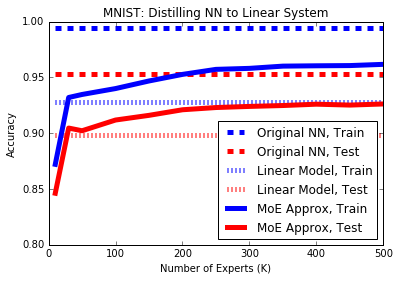

In [110]:
plt.plot([k*10 for k in Ks], [og_net_train_acc]*len(Ks), 'b--', linewidth=5, label="Original NN, Train")
plt.plot([k*10 for k in Ks], [og_net_test_acc]*len(Ks), 'r--', linewidth=5, label="Original NN, Test")

plt.plot([k*10 for k in Ks], [baseline_train_acc]*len(Ks), 'b:', linewidth=5, label="Linear Model, Train")
plt.plot([k*10 for k in Ks], [baseline_test_acc]*len(Ks), 'r:', linewidth=5, label="Linear Model, Test")

plt.plot([k*10 for k in Ks], all_train, 'b-', linewidth=5, label="MoE Approx, Train")
plt.plot([k*10 for k in Ks], all_test, 'r-', linewidth=5, label="MoE Approx, Test")

plt.xlabel("Number of Experts (K)")
plt.ylabel("Accuracy")
plt.ylim([.80, 1])

plt.title("MNIST: Distilling NN to Linear System")
plt.legend(loc=4)
plt.show()